# Config & Import Libraries

In [1]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# imports time series
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# pip install calmap
#import calmap

# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error

# misc
import os
import datetime
import itertools
import pickle
from datetime import timedelta

# apartado ts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb

# Data Loading

In [2]:
# Leemos los ficheros
ruta = '../data/'
df_forecast = pd.read_csv(ruta+'daily_sales_cleandata.csv')

In [ ]:
df_forecast.head()

,id,item,category,department,store,store_code,region,d,qty_sold,date,weekday_int,holiday,weekend,yearweek,sell_price
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,12.7414
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,5.2801
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,3.9501
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,5.7722
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,3.9634


In [ ]:
# Pasamos la variable 'date' a tipo fecha:
#df_forecast["date"] = pd.to_datetime(df_forecast["date"], format = "%Y-%m-%d")

In [3]:
# Generamos una nueva columna como 'week_day' para poder utilizarla como index:
df_forecast['year'] = df_forecast['yearweek'].astype(str).str[:4]
df_forecast['week'] = df_forecast['yearweek'].astype(str).str[4:] 
df_forecast['week_day'] = pd.to_datetime(df_forecast['year'] + df_forecast['week'] + '-1', format='%Y%U-%w')

In [4]:
#df_forecast.to_csv(ruta+'df_forecast.csv', index=False)

In [5]:
# Borramos aquellas variables que no suman al modelo:
df_forecast.drop(['d','date','weekend', 'weekday_int','yearweek'], inplace=True, axis=1)

In [6]:
# Codigo de prueba:
df_forecast.groupby(['store','store_code','region'])['qty_sold'].sum().to_frame().sort_values(by='qty_sold', ascending=False)

,,,qty_sold
store,store_code,region,
Tribeca,NYC_3,New York,11188180
Greenwich_Village,NYC_1,New York,7698216
Roxbury,BOS_2,Boston,7214384
Yorktown,PHI_2,Philadelphia,6544012
Queen_Village,PHI_3,Philadelphia,6427782
Back_Bay,BOS_3,Boston,6089330
Harlem,NYC_2,New York,5685475
South_End,BOS_1,Boston,5595292
Midtown_Village,PHI_1,Philadelphia,5149062


In [7]:
'id'

'id'

In [8]:
# Importo el dataset de test:
df_test = pd.read_csv(ruta+'df_test.csv',delimiter=';')

In [9]:
# Transformo algunas columnas al mismo tipo de dato que el dataset de forecast:
df_test['year'] = df_test['year'].astype(str)
df_test['week'] = df_test['week'].astype(str)
df_test['week_day'] = pd.to_datetime(df_test['year'] + df_test['week'] + '-1', format='%Y%U-%w')

In [10]:
# Unimos los dos datasets:
df_forecast = pd.concat([df_forecast, df_test], ignore_index=True)

In [11]:
df_forecast.tail()

,id,item,category,department,store,store_code,region,qty_sold,holiday,sell_price,year,week,week_day
58449325,SUPERMARKET_3_827_NYC_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,NaN,0,NaN,2016,20,2016-05-16
58449326,SUPERMARKET_3_827_NYC_4,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Brooklyn,NYC_4,New York,NaN,0,NaN,2016,20,2016-05-16
58449327,SUPERMARKET_3_827_PHI_1,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Midtown_Village,PHI_1,Philadelphia,NaN,0,NaN,2016,20,2016-05-16
58449328,SUPERMARKET_3_827_PHI_2,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Yorktown,PHI_2,Philadelphia,NaN,0,NaN,2016,20,2016-05-16
58449329,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,NaN,0,NaN,2016,20,2016-05-16


# Asignación de valores numericos a los nulos:

In [12]:
df_forecast.isnull().sum()

id                 0
item               0
category           0
department         0
store              0
store_code         0
region             0
qty_sold      121960
holiday            0
sell_price    121960
year               0
week               0
week_day           0
dtype: int64

In [13]:
# Asignamos valores a sell_price:
df_forecast['sell_price'] = df_forecast.groupby(['id'])['sell_price'].transform(lambda series: series.bfill().ffill())

In [14]:
# Reemplazamos los valores NaN de 'qty_sold' con cero, ya que son los valores a predecir:
df_forecast['qty_sold'].fillna(0, inplace=True)

# Data Transformation: creacion de diccionarios.

In [15]:
store_dict = {

    'South_End': 1,
    'Roxbury': 2,
    'Back_Bay': 3,
    'Greenwich_Village': 4,
    'Harlem' : 5,
    'Tribeca': 6, 
    'Brooklyn': 7,
    'Midtown_Village': 8,
    'Yorktown':9, 
    'Queen_Village': 10

}

df_forecast["store_encode"]=df_forecast["store"].map(store_dict)

In [16]:
department_dict = {
          
    'HOME_&_GARDEN_1' : 1,   
    'HOME_&_GARDEN_2' : 2, 
    'ACCESORIES_1' : 3,      
    'ACCESORIES_2': 4,
    'SUPERMARKET_1': 5,
    'SUPERMARKET_2': 6,  
    'SUPERMARKET_3': 7  

}

df_forecast["department_encode"]=df_forecast["department"].map(department_dict)

In [17]:
category_dict = {

    'SUPERMARKET': 1,
    'HOME_&_GARDEN': 2,
    'ACCESORIES': 3
   
}

df_forecast["category_encode"]=df_forecast["category"].map(category_dict)

In [18]:
region_dict ={

    'New York': 1,
    'Boston': 2,
    'Philadelphia':3

}

df_forecast["region_encode"]=df_forecast["region"].map(region_dict)

In [19]:
store_code_dict ={

    'NYC_1': 1,
    'NYC_2': 2,
    'NYC_3': 3,
    'NYC_4': 4,
    'BOS_1': 5,
    'BOS_2': 6,
    'BOS_3': 7,
    'PHI_1': 8,
    'PHI_2': 9,
    'PHI_3': 10

}

df_forecast["store_code_encode"]=df_forecast["store_code"].map(store_code_dict)

In [20]:
df_forecast['item_encoded'] = df_forecast['item'].str[-3:].astype(int)

In [21]:
df_forecast['year'] = df_forecast['year'].astype(int)
df_forecast['week'] = df_forecast['week'].astype(int)


In [22]:
df_forecast.head(5)

,id,item,category,department,store,store_code,region,qty_sold,holiday,sell_price,year,week,week_day,store_encode,department_encode,category_encode,region_encode,store_code_encode,item_encoded
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0.0,0,12.7414,2011,4,2011-01-24,4,3,3,1,1,1
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0.0,0,5.2801,2011,4,2011-01-24,4,3,3,1,1,2
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0.0,0,3.9501,2011,4,2011-01-24,4,3,3,1,1,3
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0.0,0,5.7722,2011,4,2011-01-24,4,3,3,1,1,4
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0.0,0,3.9634,2011,4,2011-01-24,4,3,3,1,1,5


In [23]:
# Borramos las columnas encodeadas:
df_forecast.drop([
                    'category',
                    'department', 
                    'region', 
                    'store', 
                    'store_code',
                    'item'], 
                    axis=1, inplace=True)

In [24]:
df_forecast.head()

,id,qty_sold,holiday,sell_price,year,week,week_day,store_encode,department_encode,category_encode,region_encode,store_code_encode,item_encoded
0,ACCESORIES_1_001_NYC_1,0.0,0,12.7414,2011,4,2011-01-24,4,3,3,1,1,1
1,ACCESORIES_1_002_NYC_1,0.0,0,5.2801,2011,4,2011-01-24,4,3,3,1,1,2
2,ACCESORIES_1_003_NYC_1,0.0,0,3.9501,2011,4,2011-01-24,4,3,3,1,1,3
3,ACCESORIES_1_004_NYC_1,0.0,0,5.7722,2011,4,2011-01-24,4,3,3,1,1,4
4,ACCESORIES_1_005_NYC_1,0.0,0,3.9634,2011,4,2011-01-24,4,3,3,1,1,5


In [25]:
# Renombramos 'week_day' como 'date':
df_forecast.rename(columns={'week_day': 'date'}, inplace=True)

In [26]:
df = df_forecast.copy()

# Visualizamos las ventas

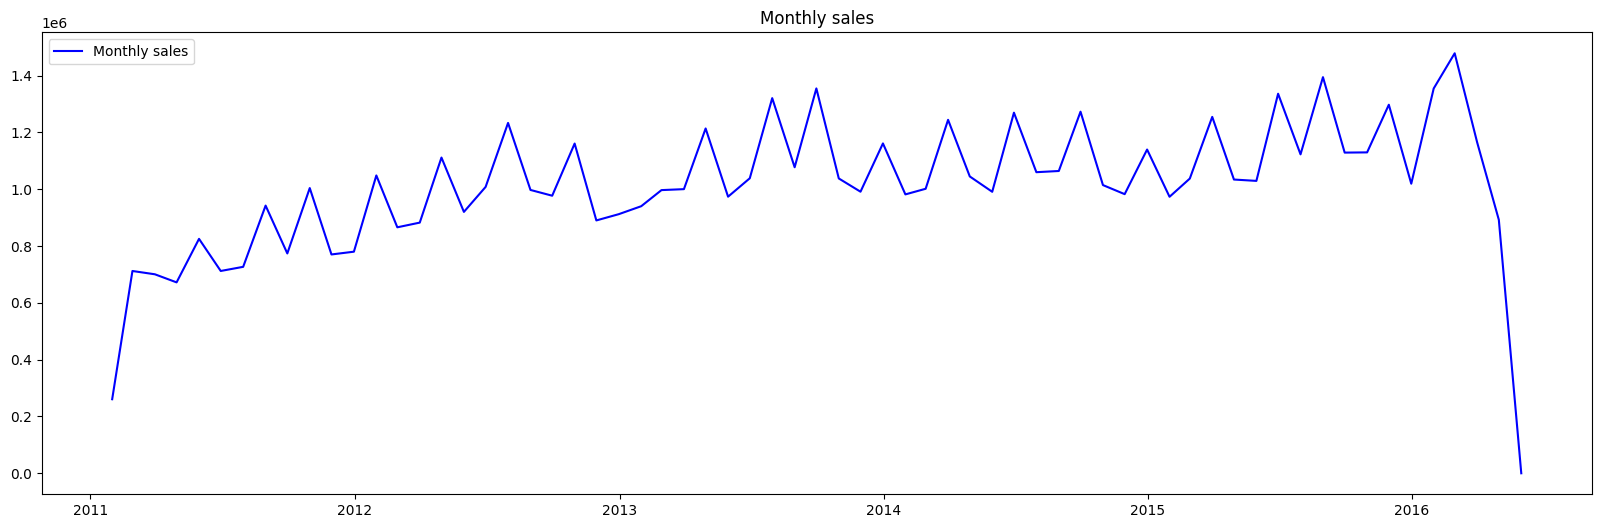

In [27]:
# Consultamos las ventas mensuales:
x= df[['date', "qty_sold"]].set_index('date').resample("M").sum()

# Vemos la evolución de las ventas mensuales:
plt.figure(figsize = (20, 6))
plt.plot(x, color = "blue", label = "Monthly sales")
plt.title("Monthly sales")
plt.legend()

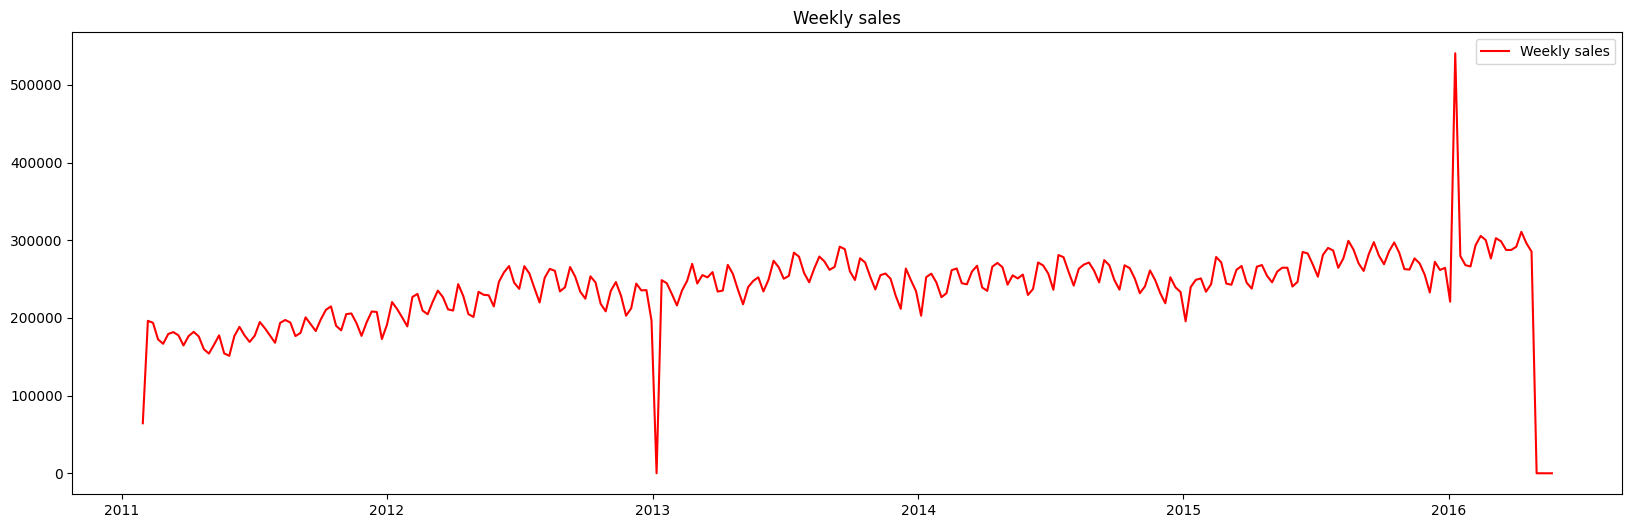

In [28]:
# Consultamos las ventas semanales:
x= df[['date', "qty_sold"]].set_index('date').resample("W").sum()

# Vemos la evolución de las ventas semanales:
plt.figure(figsize = (20, 6))
plt.plot(x, color = "red", label = "Weekly sales")
plt.title("Weekly sales")
plt.legend()

### EDA: Global Sales

In [29]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

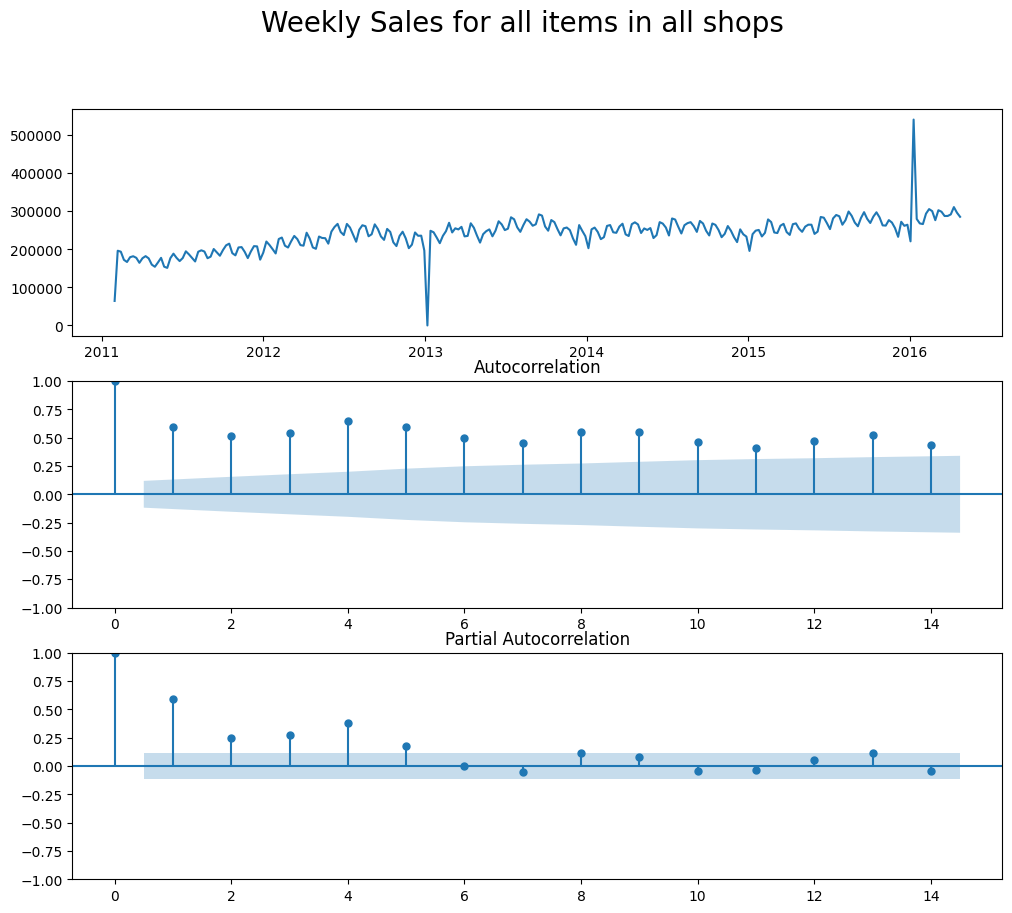

In [30]:
y = df.set_index("date").resample("W")["qty_sold"].sum()[:-4] # quitamos los registros de las ultimas cuatro semanas.
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops")

# >> Building Time Series Features:

In [31]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name):

    assert "date" in df.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("W", origin ='start')[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    gb_df_[f"{new_name}_lag5"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(5)
    )
    gb_df_[f"{new_name}_ma5"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1).rolling(5).mean()
    )
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

In [32]:
GB_LIST = ['department_encode', 'item_encoded','store_code_encode']
TARGET_COLUMN = "qty_sold"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)
vars_ts_['date'] = vars_ts_['date'] - timedelta(days=6)
vars_ts_.head(10)


Dropping columns that might cause target leakage department_encode_item_encoded_store_code_encode_qty_sold_sum


,department_encode,item_encoded,store_code_encode,date,department_encode_item_encoded_store_code_encode_qty_sold_sum_lag5,department_encode_item_encoded_store_code_encode_qty_sold_sum_ma5
0,1,1,1,2011-01-24,NaN,NaN
1,1,1,1,2011-01-31,NaN,NaN
2,1,1,1,2011-02-07,NaN,NaN
3,1,1,1,2011-02-14,NaN,NaN
4,1,1,1,2011-02-21,NaN,NaN
5,1,1,1,2011-02-28,3.0,2.4
6,1,1,1,2011-03-07,1.0,2.0
7,1,1,1,2011-03-14,4.0,2.4
8,1,1,1,2011-03-21,2.0,1.6
9,1,1,1,2011-03-28,2.0,1.4


In [33]:
print(df.shape)
df = pd.merge(df, vars_ts_, on = ["date"] + GB_LIST, how = "left")
print(df.shape)

(58449330, 13)
(58449330, 15)


In [34]:
df.tail()

,id,qty_sold,holiday,sell_price,year,week,date,store_encode,department_encode,category_encode,region_encode,store_code_encode,item_encoded,department_encode_item_encoded_store_code_encode_qty_sold_sum_lag5,department_encode_item_encoded_store_code_encode_qty_sold_sum_ma5
58449325,SUPERMARKET_3_827_NYC_3,0.0,0,1.2,2016,20,2016-05-16,6,7,1,1,3,827,39.0,15.4
58449326,SUPERMARKET_3_827_NYC_4,0.0,0,1.2,2016,20,2016-05-16,7,7,1,1,4,827,0.0,4.4
58449327,SUPERMARKET_3_827_PHI_1,0.0,0,1.2,2016,20,2016-05-16,8,7,1,3,8,827,20.0,7.0
58449328,SUPERMARKET_3_827_PHI_2,0.0,0,1.2,2016,20,2016-05-16,9,7,1,3,9,827,17.0,5.8
58449329,SUPERMARKET_3_827_PHI_3,0.0,0,1.2,2016,20,2016-05-16,10,7,1,3,10,827,0.0,0.0


In [35]:
'''GB_LIST = ['store_encode','id']     
TARGET_COLUMN = "sell_price"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)
vars_ts_['date'] = vars_ts_['date'] - timedelta(days=6)
vars_ts_.head(10)

print(df.shape)
df = pd.merge(df, vars_ts_, on = ["date"] + GB_LIST, how = "left")
print(df.shape)'''

'GB_LIST = [\'store_encode\',\'id\']     \nTARGET_COLUMN = "sell_price"\nAGG_FUNC = np.sum\nAGG_FUNC_NAME = "sum"\n\nvars_ts_ = build_ts_vars(\n    df = df,\n    gb_list = GB_LIST,\n    target_column = TARGET_COLUMN,\n    agg_func = AGG_FUNC,\n    agg_func_name =  AGG_FUNC_NAME\n\n)\nvars_ts_[\'date\'] = vars_ts_[\'date\'] - timedelta(days=6)\nvars_ts_.head(10)\n\nprint(df.shape)\ndf = pd.merge(df, vars_ts_, on = ["date"] + GB_LIST, how = "left")\nprint(df.shape)'

In [36]:
#df['sales_mean_rolling'] = df.groupby(['id']).resample('W')['qty_sold'].transform(lambda series: series.shift(1).rolling(window = 2).mean())

In [37]:
#df.head(3)

### Train Test Split

In [38]:
df.columns.tolist()

['id',
 'qty_sold',
 'holiday',
 'sell_price',
 'year',
 'week',
 'date',
 'store_encode',
 'department_encode',
 'category_encode',
 'region_encode',
 'store_code_encode',
 'item_encoded',
 'department_encode_item_encoded_store_code_encode_qty_sold_sum_lag5',
 'department_encode_item_encoded_store_code_encode_qty_sold_sum_ma5']

In [39]:
COLUMNS_TO_DROP = ['store_encode','region_encode','category_encode'
    #'year','week'
]

df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [40]:
df.set_index("id", inplace = True)

In [41]:
df.sample(5)

,qty_sold,holiday,sell_price,year,week,date,department_encode,store_code_encode,item_encoded,department_encode_item_encoded_store_code_encode_qty_sold_sum_lag5,department_encode_item_encoded_store_code_encode_qty_sold_sum_ma5
id,,,,,,,,,,,
HOME_&_GARDEN_1_384_BOS_2,0.0,0,6.0500,2011,23,2011-06-06,1,6,384,0.0,0.0
HOME_&_GARDEN_1_011_NYC_1,0.0,0,5.7875,2016,13,2016-03-28,1,1,11,11.0,11.4
ACCESORIES_2_117_NYC_2,2.0,0,3.6841,2014,1,2014-01-06,4,2,117,0.0,0.0
SUPERMARKET_3_362_BOS_2,23.0,0,3.0000,2013,50,2013-12-16,7,6,362,264.0,178.4
HOME_&_GARDEN_1_314_PHI_1,0.0,0,9.9750,2011,37,2011-09-12,1,8,314,0.0,0.0


In [42]:
# Hacemos el split del dataset:
X_train = df[(df['date'] <= '2016-03-21')].drop(['qty_sold', "date"], axis=1)
Y_train = df[(df['date'] <= '2016-03-21')]['qty_sold']

X_valida = df[(df['date'] >= '2016-03-28') & (df['date'] <= '2016-04-18')].drop(['qty_sold', "date"], axis=1)
Y_valida = df[(df['date'] >= '2016-03-28') & (df['date'] <= '2016-04-18')]['qty_sold']

X_test = df[(df['date'] >= '2016-04-25')].drop(['qty_sold', "date"], axis = 1)
Y_test = df[(df['date'] >= '2016-04-25')]['qty_sold']

In [43]:
X_train.tail(3)

,holiday,sell_price,year,week,department_encode,store_code_encode,item_encoded,department_encode_item_encoded_store_code_encode_qty_sold_sum_lag5,department_encode_item_encoded_store_code_encode_qty_sold_sum_ma5
id,,,,,,,,,
SUPERMARKET_3_825_PHI_3,1,4.776,2016,12,7,10,825,4.0,7.4
SUPERMARKET_3_826_PHI_3,1,1.536,2016,12,7,10,826,9.0,6.6
SUPERMARKET_3_827_PHI_3,1,1.200,2016,12,7,10,827,9.0,11.2


In [44]:
Y_valida.tail(3)

id
SUPERMARKET_3_825_PHI_3    0.0
SUPERMARKET_3_826_PHI_3    3.0
SUPERMARKET_3_827_PHI_3    0.0
Name: qty_sold, dtype: float64

# Hiper-parametrizacion

In [45]:
'''from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 75, 100, 150],
    'max_depth': [5, 6, 7],
    'gamma' : [0, 0.1, 0.2],
#    'reg_alpha' : [0, 0.1, 0.01],
#    'reg_lambda': [0.9, 1, 1.1],
    'learning_rate' : [0.1, 0.25, 0.3]
}

grid_search = GridSearchCV(xgb.XGBRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = False)

model = grid_search.best_estimator_'''

"from sklearn.model_selection import GridSearchCV\n\nparam_grid = {\n    'n_estimators': [50, 75, 100, 150],\n    'max_depth': [5, 6, 7],\n    'gamma' : [0, 0.1, 0.2],\n#    'reg_alpha' : [0, 0.1, 0.01],\n#    'reg_lambda': [0.9, 1, 1.1],\n    'learning_rate' : [0.1, 0.25, 0.3]\n}\n\ngrid_search = GridSearchCV(xgb.XGBRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')\ngrid_search.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = False)\n\nmodel = grid_search.best_estimator_"

In [46]:
'''print("---- Results from Random Search -----" )
print("\n The best estimator across ALL searched params:", grid_search.best_estimator_)
print("\n The best RMSE:", grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_search.best_params_)'''

'print("---- Results from Random Search -----" )\nprint("\n The best estimator across ALL searched params:", grid_search.best_estimator_)\nprint("\n The best RMSE:", grid_search.best_score_)\nprint("\n The best parameters across ALL searched params:\n", grid_search.best_params_)'

# Model Train

In [47]:
model = xgb.XGBRegressor(
              eval_metric = "rmse",
              seed = 175
#              , n_estimators = 75
#              , max_depth = 6
#              , gamma = 0
#              , reg_alpha =0
#              , reg_lambda = 1
#              , learning_rate = 0.1
              )

model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = 10)

[0]	validation_0-rmse:3.25222	validation_1-rmse:2.94454
[10]	validation_0-rmse:2.43887	validation_1-rmse:2.16889
[20]	validation_0-rmse:2.40056	validation_1-rmse:2.16439
[30]	validation_0-rmse:2.38582	validation_1-rmse:2.15425
[40]	validation_0-rmse:2.37568	validation_1-rmse:2.14926
[50]	validation_0-rmse:2.36293	validation_1-rmse:2.14953
[60]	validation_0-rmse:2.35417	validation_1-rmse:2.14638
[70]	validation_0-rmse:2.34520	validation_1-rmse:2.14559
[80]	validation_0-rmse:2.32977	validation_1-rmse:2.14125
[90]	validation_0-rmse:2.32155	validation_1-rmse:2.13960
[99]	validation_0-rmse:2.31486	validation_1-rmse:2.13730


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### >> Model Evaluation

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

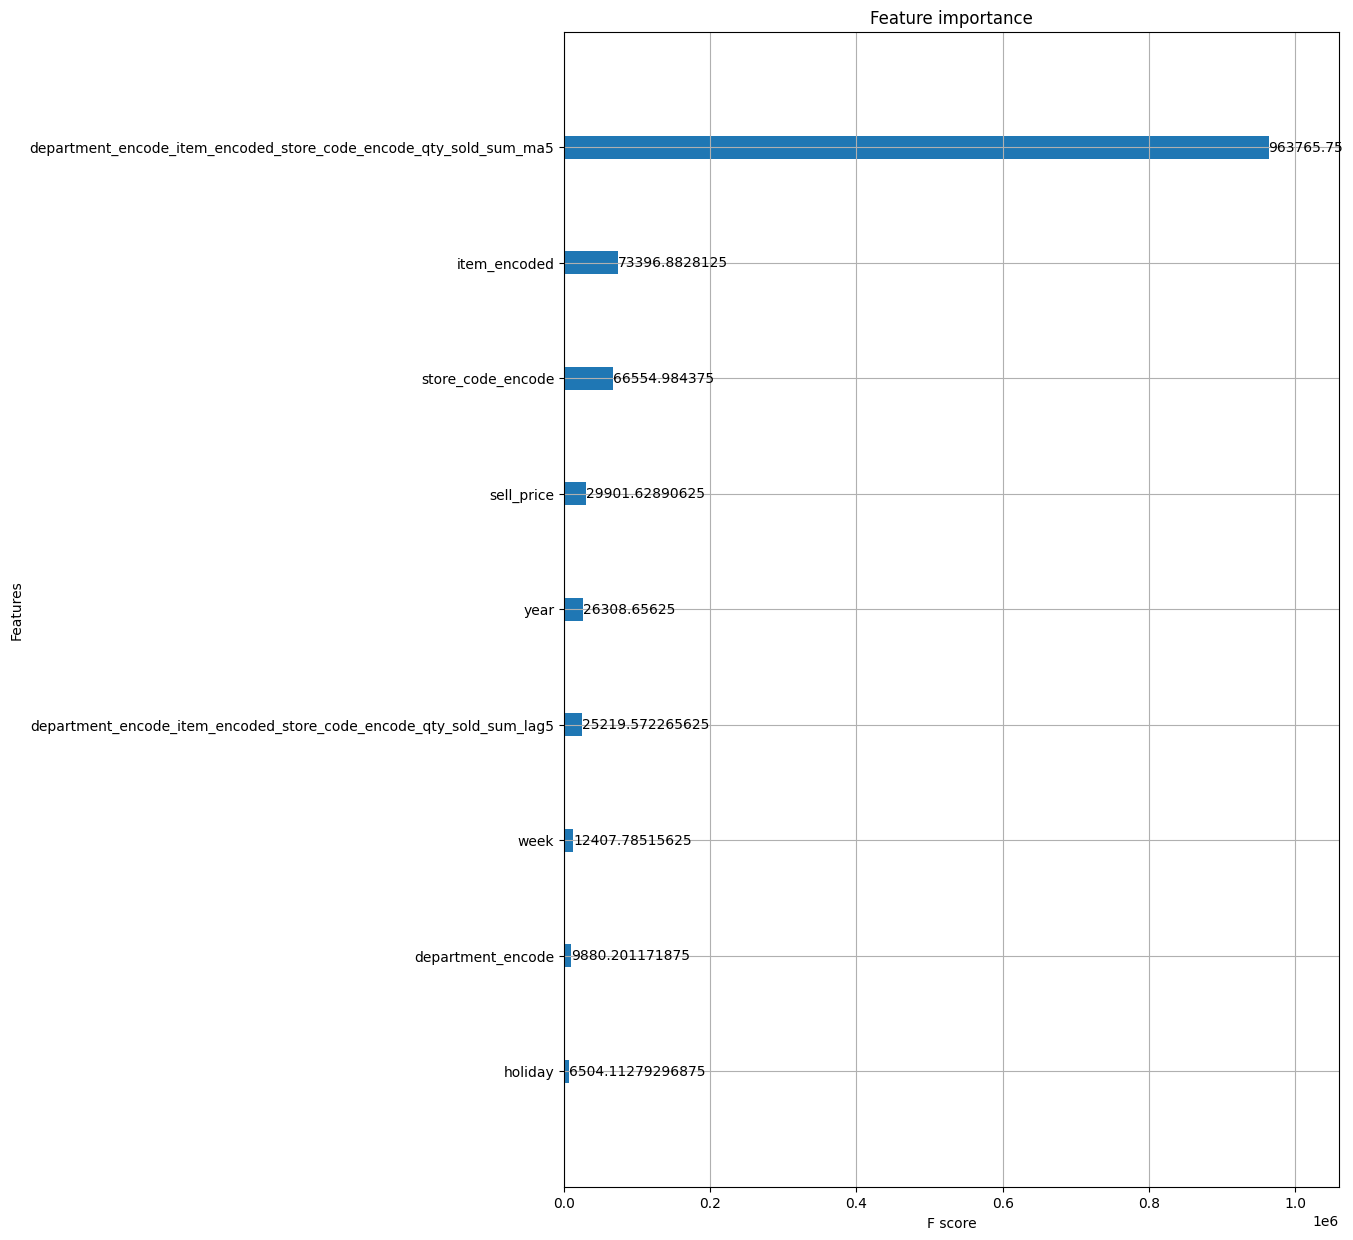

In [48]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax)

# Prediction

In [49]:
if "qty_sold" in X_test.columns:
    X_test.drop("qty_sold", axis = 1, inplace = True)

Y_test_predict = model.predict(X_test)
X_test["qty_sold"] = Y_test_predict

In [50]:
X_test.reset_index(inplace = True)

In [51]:
X_test.tail()

,id,holiday,sell_price,year,week,department_encode,store_code_encode,item_encoded,department_encode_item_encoded_store_code_encode_qty_sold_sum_lag5,department_encode_item_encoded_store_code_encode_qty_sold_sum_ma5,qty_sold
121955,SUPERMARKET_3_827_NYC_3,0,1.2,2016,20,7,3,827,39.0,15.4,1.993438
121956,SUPERMARKET_3_827_NYC_4,0,1.2,2016,20,7,4,827,0.0,4.4,1.431291
121957,SUPERMARKET_3_827_PHI_1,0,1.2,2016,20,7,8,827,20.0,7.0,0.793987
121958,SUPERMARKET_3_827_PHI_2,0,1.2,2016,20,7,9,827,17.0,5.8,0.994539
121959,SUPERMARKET_3_827_PHI_3,0,1.2,2016,20,7,10,827,0.0,0.0,0.259157


In [52]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [53]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 2_315
Validation RMSE: 2_137


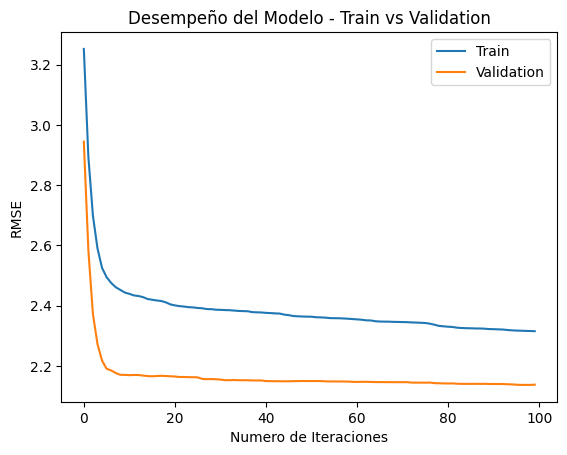

In [54]:
# Obtener métricas
results = model.evals_result()
# Gráfica de métricas
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# Métricas de entrenamiento
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
# Métricas de validação
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
plt.legend()
plt.xlabel('Numero de Iteraciones')
plt.ylabel('RMSE')
plt.title('Desempeño del Modelo - Train vs Validation')
plt.show()

In [55]:
X_test.tail(3)

,id,holiday,sell_price,year,week,department_encode,store_code_encode,item_encoded,department_encode_item_encoded_store_code_encode_qty_sold_sum_lag5,department_encode_item_encoded_store_code_encode_qty_sold_sum_ma5,qty_sold
121957,SUPERMARKET_3_827_PHI_1,0,1.2,2016,20,7,8,827,20.0,7.0,0.793987
121958,SUPERMARKET_3_827_PHI_2,0,1.2,2016,20,7,9,827,17.0,5.8,0.994539
121959,SUPERMARKET_3_827_PHI_3,0,1.2,2016,20,7,10,827,0.0,0.0,0.259157


In [56]:
X_test['qty_sold'] = X_test['qty_sold'].astype(int)

In [57]:
# Resultado de la prediccion:
X_test[['year','week','id','qty_sold']]

,year,week,id,qty_sold
0,2016,17,ACCESORIES_1_001_BOS_1,0
1,2016,17,ACCESORIES_1_001_BOS_2,0
2,2016,17,ACCESORIES_1_001_BOS_3,0
3,2016,17,ACCESORIES_1_001_NYC_1,0
4,2016,17,ACCESORIES_1_001_NYC_2,0
...,...,...,...,...
121955,2016,20,SUPERMARKET_3_827_NYC_3,1
121956,2016,20,SUPERMARKET_3_827_NYC_4,1
121957,2016,20,SUPERMARKET_3_827_PHI_1,0
121958,2016,20,SUPERMARKET_3_827_PHI_2,0


In [58]:
'''Train RMSE: 3_553
Validation RMSE: 3_294
Diferencia = 0.259

Dataset standard
-----------------------------------------
Train RMSE: 2_265
Validation RMSE: 2_113
Diferencia = 0.152

'store_encode_id_qty_sold_sum_lag1',
'store_encode_id_qty_sold_sum_ma3'
-----------------------------------------
Train RMSE: 2_316
Validation RMSE: 2_142
Diferencia = 0.175

 'category_encode_department_encode_item_encoded_region_encode_store_code_encode_qty_sold_sum_lag5',
 'category_encode_department_encode_item_encoded_region_encode_store_code_encode_qty_sold_sum_ma5'
-----------------------------------------
Train RMSE: 2_315
Validation RMSE: 2_137
Diferencia = 0.178

Borre: category, store y region. 
-----------------------------------------


'''

"Train RMSE: 3_553\nValidation RMSE: 3_294\nDiferencia = 0.259\n\nDataset estandard\n-----------------------------------------\nTrain RMSE: 2_265\nValidation RMSE: 2_113\nDiferencia = 0.152\n\n'store_encode_id_qty_sold_sum_lag1',\n'store_encode_id_qty_sold_sum_ma3'\n-----------------------------------------\nTrain RMSE: 2_316\nValidation RMSE: 2_142\nDiferencia = 0.175\n\n 'category_encode_department_encode_item_encoded_region_encode_store_code_encode_qty_sold_sum_lag5',\n 'category_encode_department_encode_item_encoded_region_encode_store_code_encode_qty_sold_sum_ma5'\n-----------------------------------------\n\n"